## Install libraries

In [2]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import os
from datetime import datetime
import shutil
import logging
import requests

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from scipy.stats import scoreatpercentile

from sklearn.model_selection import train_test_split, StratifiedKFold

from datasets import DatasetDict, Dataset, load_dataset # for data load
import evaluate
import transformers
from transformers import AutoTokenizer # Tokenisation
from transformers import AutoModelForSequenceClassification # Classification
from transformers import TrainingArguments # To setup training arguments
from transformers import Trainer 

from typing import Dict

from scipy.special import softmax

from transformers import set_seed

import sys
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


## Setup/create folder paths and global parameters

In [45]:
SEED = 2023


# URLs and paths
DATA_URL = 'https://gist.githubusercontent.com/nsmathew/9354f08d7924da387aa22efaa8bb1a18/raw/75f2b40f8fefc1ab458e775b0a104670df6e45f5/complaint_severity_data.csv'
DATA_DIR = "/notebooks/complaints/data/"
DATA_FILE = os.path.join(DATA_DIR, "complaints_severity.csv")
OUTPUT_DIR = "/notebooks/complaints/outputs/"
LOGS_DIR = "/notebooks/complaints/logs/error_analysis/" # Save all logs including training and testing performance
REPORTS_DIR = "/notebooks/complaints/reports/error_analysis/"
FIGURES_DIR = "/notebooks/complaints/figures/"

# Create directories if they do not exists
prog_paths = [DATA_DIR, OUTPUT_DIR, LOGS_DIR, REPORTS_DIR, FIGURES_DIR]
for path in prog_paths:
    if not os.path.exists(path):
        os.makedirs(path)

# Logging for transformers
transformers.utils.logging.set_verbosity_error
LOG_TIMESTAMP = "none"

EVAL_METRICS_REP = None
TRAIN_METRICS_REP = None
TEST_METRICS_REP = None
MEAN_TEST_METRICS_REP = None
CONF_MATRIX_REP = None
MEAN_CONF_MATRIX_REP = None

# Where checkpoints are saved
CHECKPOINT_PATHS = ["/notebooks/train_trainer", "/notebooks/test_trainer"] # test_trainer is the default name used

# Training params
NO_OF_EPOCHS = 4
OUTER_CV_NO = 6
INNER_CV_NO = 4
#INNER_CV_NO = 3
MAX_LENGTH=50
LR_SPACE = [1e-5, 5e-6, 5e-5, 3e-5]
#LR_SPACE = [3e-5, 3e-5, 3e-5]
#LR_SPACE = [3e-4, 1e-4]

# Additional setup for cross domain experiments
DOMAINS = ['food', 'apparel', 'cars', 'retail', 'services', 'software', 'transport', 'electronics', 'other']
CROSSDOMAIN_CV = 3

In [4]:
def create_histogram(plot_data, plot_filename, plot_title, plot_xlabel, plot_ylabel, plot_xscale, plot_yscale, show_95th=False):  
    plt.figure(figsize=(8, 4))
    plt.hist(plot_data, bins=20, color='skyblue', edgecolor='black')
    percentile_95 = plot_data.quantile(0.95)
    if show_95th:
        print("95th percentile:", percentile_95, "%")
    plt.axvline(x=percentile_95, color='red', linestyle='dashed', label='95th Percentile')
    plt.xlabel(plot_xlabel, fontsize=14)
    plt.ylabel(plot_ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(plot_xscale[0], plot_xscale[1]) 
    plt.ylim(plot_yscale[0], plot_yscale[1]) 
    plt.title(plot_title, fontsize=12)
    plt.grid(True)
    plt.savefig(FIGURES_DIR + "/" + plot_filename)
    plt.show()

## Download, read the raw data and load into dataset objects

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
    label                                               text
0      0  can i return online purchases to a house of fr...
1      0  hi - i'm writing a piece for msn him and wonde...
2      0                           i need to check my 

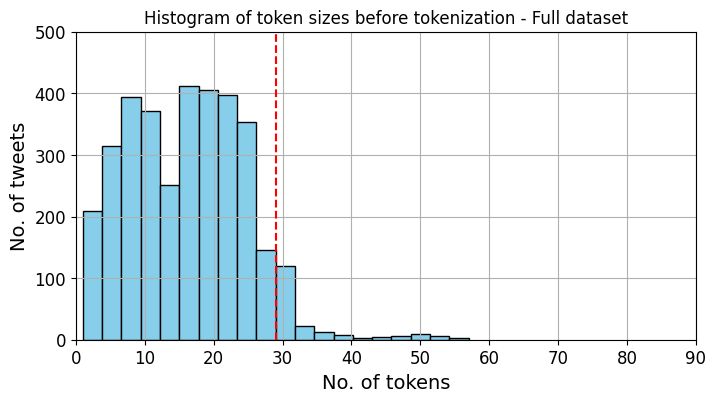

Number of rows with token size > 50: 10
Percentage of rows with token size > 50: 0.29%


In [5]:
def read_data(require_domain=False):
    # Download the data file and save it 
    response = requests.get(DATA_URL)
    if response.status_code == 200:
        with open(DATA_FILE, 'wb') as file:
            file.write(response.content)
        print("Data file downloaded and saved successfully...")
    else:
        print("Failed to download data file...")
        return
    raw_df = pd.read_csv(DATA_FILE, header=None, names=['id', 'text', 'binarylabel', 'multilabel', 'domain'])
    # binary label - 1 is a complain and 0 is not
    print("Sample Data--\n", raw_df.head())
    print("Data Length--",len(raw_df))
    if require_domain:
        upd_df = pd.DataFrame({
            'domain': raw_df["domain"],
            'label': raw_df["binarylabel"],
            'text': raw_df["text"]
        })
    else:
        upd_df = pd.DataFrame({
        #'idx':range(len(raw_df)),
        'label': raw_df["binarylabel"],
        'text': raw_df["text"]
    })
    print("Sample Data after transformation--\n", upd_df.head())
    print("Data Length after transformation--",len(upd_df))
    return upd_df

# Read data here to get the stats, histogram and populate objects for the non cv run
upd_df = read_data()

# Calculate token lengths
upd_df['token_count'] = upd_df['text'].apply(lambda x: len(x.split()))
print(upd_df['token_count'])
# Calculate statistics
max_tokens = upd_df['token_count'].max()
min_tokens = upd_df['token_count'].min()
avg_tokens = upd_df['token_count'].mean()
# Print statistics
print(f"Maximum Tokens: {max_tokens}")
print(f"Minimum Tokens: {min_tokens}")
print(f"Average Tokens: {avg_tokens:.2f}")

# Create a histogram
create_histogram(upd_df['token_count'],
                 "token_hist.png",
                 'Histogram of token sizes before tokenization - Full dataset',
                 'No. of tokens',
                 'No. of tweets',
                 [0, 90],                 
                 [0, 500],
                 True)

# Calculate the number of rows with token size > 50
percentage_above_50 = (len(upd_df[upd_df['token_count'] > 50]) / len(upd_df)) * 100

# Print the results
print(f"Number of rows with token size > 50: {len(upd_df[upd_df['token_count'] > 50])}")
print(f"Percentage of rows with token size > 50: {percentage_above_50:.2f}%")


# Split the dataset, to be used if running in the non CV train and test and
temp_df, test_df = train_test_split(upd_df, test_size=0.2, random_state=SEED)
train_df, dev_df = train_test_split(temp_df, test_size=0.1, random_state=SEED)
#print("Train, Dev and Test sizes--", len(train_df), len(dev_df), len(test_df))
train_ds = Dataset.from_pandas(train_df)
dev_ds = Dataset.from_pandas(dev_df)
test_ds = Dataset.from_pandas(test_df)
twt_datasets = DatasetDict()
twt_datasets['train'] = train_ds
twt_datasets['dev'] = dev_ds
twt_datasets['test'] = test_ds
#print(twt_datasets)

## Function Defintions

### Pre-processing functions

In [6]:
tokenizer = None # Create a global tokeniser objet for code simplicity

# Function to perform tokenisation on a dataset
def data_tokenizer(examples):
    global MAX_LENGTH
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

# Function to tokenise all datasets using AutoTokenizer
def tokenise_datasets(llm_model, twt_datasets, ds_type="all"):
    global tokenizer
    train_dataset = None
    dev_dataset = None 
    test_dataset = None
    tokenizer = AutoTokenizer.from_pretrained(llm_model, 
                                              use_fast=True)
    print(tokenizer)
    tokenized_data = twt_datasets.map(data_tokenizer, 
                                      batched=True)
    if ds_type in ["all", "incl_dev", "incl_test"]:
        train_dataset = tokenized_data["train"]
    if ds_type in ["all", "incl_dev"]:
        dev_dataset = tokenized_data["dev"]
    if ds_type in ["all", "incl_test", "test_only"]:
        test_dataset = tokenized_data["test"]
    try:
        logging.info("Data sizes-- Train: " + str(len(train_dataset)) + " Dev: " + str(len(dev_dataset)) + " Test: " + str(len(test_dataset)))
    except TypeError:
        pass
    return train_dataset, dev_dataset, test_dataset

### Metrics function 

In [7]:
acc_metric = evaluate.load("accuracy")
prec_metric = evaluate.load("precision")
rcl_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1") 
auc_metric = evaluate.load("roc_auc") 
matthews_metric = evaluate.load("matthews_correlation")

# Function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred    
    predictions = np.argmax(logits, axis=-1)
    results = {}
    results.update(acc_metric.compute(predictions=predictions, references=labels))
    results.update(prec_metric.compute(predictions=predictions, references=labels))
    results.update(rcl_metric.compute(predictions=predictions, references=labels))
    results.update(f1_metric.compute(predictions=predictions, references=labels))
    results.update(auc_metric.compute(prediction_scores=predictions, references=labels))
    results.update(matthews_metric.compute(predictions=predictions, references=labels))
    
    return results

In [8]:
def compute_confusion_matrix(predictions, labels):
    conf_matrix = {}
    conf_metric = evaluate.load("BucketHeadP65/confusion_matrix") 
    conf_matrix.update(conf_metric.compute(predictions=predictions, references=labels))
    return conf_matrix

### Fine-tuning and evaluation function

In [9]:
# Override the log() to include the learning from the scheduler
class TrainerLrIncluded(Trainer):
    def log(self, logs: Dict[str, float]) -> None:
        logs["lr_from_scheduler"] = self._get_learning_rate()
        super().log(logs)

# Function to train and evaluate on validation data. Returns the trainer object
# for predictions/testing and reporting
def finetune_and_evaluate(llm_model, lr, train_dataset, dev_dataset):
    logging.info("Function finetune_and_evaluate() received model: " + llm_model + ", lr: " + str(lr))
    logging.info("Setting up training args and starting training...")
    model = AutoModelForSequenceClassification.from_pretrained(llm_model, num_labels=2)
    training_args = TrainingArguments("train_trainer", 
                                        num_train_epochs=NO_OF_EPOCHS,
                                        evaluation_strategy="epoch",
                                        save_strategy='epoch',
                                        save_steps=100,
                                        eval_steps=100,
                                        load_best_model_at_end=True,
                                        seed=SEED,
                                        report_to="none",
                                        learning_rate=lr,
                                        weight_decay=0.001
                                      )
    trainer = TrainerLrIncluded(model=model, 
                                  args=training_args, 
                                  train_dataset=train_dataset, 
                                  eval_dataset=dev_dataset,
                                  compute_metrics=compute_metrics
                                 )

    # Note: requesting evaluation on validation data as well using evaluation_strategy="epoch"
    # Hence no need to run trainer.evaluate() additionally
    results = trainer.train() 
    logging.info("Training complete...")
    logging.info(results)
    logging.info("Saving model at " + OUTPUT_DIR+"ft_"+llm_model.replace("/", "-"))
    trainer.save_model(output_dir=OUTPUT_DIR+"ft_"+llm_model.replace("/", "-"))
    return trainer

### Prediction and test data evaluation function

In [10]:
# Function to perform testing during the predict function
# Used by orchestrate_flow()
# Returns the metrics from the test
def perform_test(trainer, test_dataset):
    results = trainer.predict(test_dataset=test_dataset)
    _, _, test_metrics = results
    print("Metrics from the Predictions...")
    print(test_metrics)
    return test_metrics

In [31]:
# Function to perform testing uring the predict function
# Used by orchestrate_flow_cv()
# Returns the metrics from the test along with the confusion matrix
def perform_test_cv(best_model, test_dataset, print_misclass=False):
    trainer = Trainer(model=best_model, compute_metrics=compute_metrics)
    results = trainer.predict(test_dataset=test_dataset)
    logits, _, test_metrics = results
    predictions = np.argmax(logits, axis=-1)
    labels = np.array(test_dataset['label'])
    conf_matrix = compute_confusion_matrix(predictions, labels)
    if print_misclass:
        print_misclassifications(test_dataset, predictions)
    logging.info("Metrics from the Predictions...")
    logging.info(test_metrics)
    logging.info(conf_matrix)
    return test_metrics, conf_matrix

In [44]:
def print_misclassifications(test_dataset, predictions):
    hold_misclass_lst = []
    for i, row in enumerate(test_dataset):
        true_l = row['label']
        predicted_l = predictions[i]
        if true_l != predicted_l:
            hold_misclass_lst.append({'Text': row['text'], 'Predicted Label': predicted_l, 'True Label': true_l})
    logging.info("-"*70)
    logging.info("Misclassified instances...")
    logging.info("Text\tPredicted Label\tTrue Label") 
    logging.info("----\t---------------\t----------")
    for item in hold_misclass_lst:
        logging.info(item['Text'] + "\t" + str(item['Predicted Label']) + "\t" + str(item['True Label']))
    logging.info("-"*70)

### Function to format the metrics for logs

In [27]:
# Function to format the train, eval and testing metrics for logging
def format_metrics(llm_model, outer_cv, inner_cv, lr, train_metrics=None, test_metrics=None, mean_test_metrics=None, conf_matrix=None, mean_conf_matrix=None):
    global EVAL_METRICS_REP, TRAIN_METRICS_REP, TEST_METRICS_REP, MEAN_TEST_METRICS_REP, CONF_MATRIX_REP, MEAN_CONF_MATRIX_REP # For results reporting 
    # Accumulate the metrics separetly and then log for better formatting.
    # Simpler alternative to writing a custom logger
    formatted = "\n"
    formatted += "\nResults as of "+ LOG_TIMESTAMP + " for " + llm_model + "\n"
    if train_metrics is not None: # If trainer is not available(only prediction results)
        formatted += "***** Eval metrics *****\n"
        headers = train_metrics[0].keys()
        content = "model" + "\t" + "outer_cv" + "\t" + "inner_cv" + "\t" + "hp_set_lr" + "\t" + "\t".join(headers) + "\n"
        formatted += content
        if EVAL_METRICS_REP is None: # Add header only once
            EVAL_METRICS_REP = content
        for cnt, elem in enumerate(train_metrics):
            # Exclude the section on the train metrics.
            # Train metrics to be printed after since the headers are different
            if cnt < len(train_metrics)-1:
                try:
                    values = [str(elem[key]) for key in headers]
                    content = llm_model + "\t" + outer_cv + "\t" + inner_cv + "\t" + lr + "\t" + "\t".join(values) + "\n"
                    formatted += content
                    EVAL_METRICS_REP += content
                except KeyError: # The intermediate loss section is skipped 
                    pass
        formatted += "--*--*--\n"
        # Print the training metrics which is last element of the Trainer's state history
        # Could break if the format of the state history changes
        formatted += "***** Train metrics *****\n"        
        headers = train_metrics[-1].keys()
        content = "model" + "\t" + "outer_cv" + "\t" + "inner_cv" + "\t" + "hp_set_lr" + "\t".join(headers) + "\n"
        formatted += content
        if TRAIN_METRICS_REP is None:
            TRAIN_METRICS_REP = content
        values = [str((train_metrics[-1])[key]) for key in headers]
        content = llm_model + "\t" + outer_cv + "\t" + inner_cv + "\t" + lr + "\t" + "\t".join(values) + "\n"
        formatted += content
        TRAIN_METRICS_REP += content
    if test_metrics is not None: # Only if test_metrics is available
        formatted += "***** Test(predict) metrics *****\n"
        headers = test_metrics.keys()
        content = "model" + "\t" + "outer_cv" + "\t" + "\t".join(headers) + "\n"
        formatted += content
        if TEST_METRICS_REP is None:
            TEST_METRICS_REP = content
        values = [str(test_metrics[key]) for key in headers]        
        content = llm_model + "\t" + outer_cv + "\t" + "\t".join(values) + "\n"
        formatted += content
        TEST_METRICS_REP += content
    if conf_matrix is not None:
        formatted += "***** Confusion Matrix(predict) *****\n"
        headers = conf_matrix.keys()
        content = "model" + "\t" + "outer_cv" + "\t" + "\t".join(headers) + "\n"
        formatted += content
        if CONF_MATRIX_REP is None:
            CONF_MATRIX_REP = content
        values = [str(conf_matrix[key]) for key in headers]        
        content = llm_model + "\t" + outer_cv + "\t" + "\t".join(values) + "\n"
        formatted += content
        CONF_MATRIX_REP += content
    if mean_test_metrics is not None: # Only if mean_test_metrics is available
        formatted += "***** Mean Test(predict) metrics *****\n"
        headers = mean_test_metrics.keys()
        content = "model" + "\t" + "\t".join(headers) + "\n"
        formatted += content
        if MEAN_TEST_METRICS_REP is None:
            MEAN_TEST_METRICS_REP = content
        values = [str(mean_test_metrics[key]) for key in headers]        
        content = llm_model + "\t" + "\t".join(values) + "\n"
        formatted += content
        MEAN_TEST_METRICS_REP += content
    if mean_conf_matrix is not None:
        formatted += "***** Mean Confusion Matrix(predict) *****\n"
        headers = mean_conf_matrix.keys()
        content = "model" + "\t" + "\t".join(headers) + "\n"
        formatted += content
        if MEAN_CONF_MATRIX_REP is None:
            MEAN_CONF_MATRIX_REP = content
        values = [str(mean_conf_matrix[key]) for key in headers]        
        content = llm_model + "\t" + "\t".join(values) + "\n"
        formatted += content
        MEAN_CONF_MATRIX_REP += content        
    logging.info(formatted) # Finally print the accumulated metrics

In [26]:
# Function to create a report based on the metrics collected during finetuning and inference
def create_results_report(llm_model, total_data_count):
    file_name = REPORTS_DIR+llm_model.replace("/", "-")+"_REP_"+LOG_TIMESTAMP+".txt"
    # Write the contents of the results to the file
    with open(file_name, 'w') as file:
        file.write("Results report for " + llm_model + " as of " + LOG_TIMESTAMP + "\n")
        file.write("-"*70 + "\n")
        file.write("Training Params - NO_OF_EPOCHS: " + str(NO_OF_EPOCHS) + " OUTER_CV_NO: " + str(OUTER_CV_NO)+\
                   " INNER_CV_NO: " + str(INNER_CV_NO) + " MAX_LENGTH: " + str(MAX_LENGTH) +\
                   " LR_SPACE: " + str(LR_SPACE) + " SEED: " + str(SEED) + "\n")
        file.write("Total no. of tweets: " + str(total_data_count))
        file.write("-"*70 + "\n")
        file.write("Evaluation Metrics: \n")
        file.write(EVAL_METRICS_REP + "\n\n")
        file.write("-"*70 + "\n")
        file.write("Train Metrics: \n")
        file.write(TRAIN_METRICS_REP + "\n\n")
        file.write("-"*70 + "\n")
        file.write("Test Metrics: \n")
        file.write(TEST_METRICS_REP + "\n\n")
        file.write("-"*70 + "\n")
        file.write("Confusion Matrix: \n")
        file.write(CONF_MATRIX_REP + "\n\n")
        file.write("-"*70 + "\n")        
        file.write("Mean Test Metrics: \n")
        file.write(MEAN_TEST_METRICS_REP + "\n")
        file.write("-"*70 + "\n")        
        file.write("Mean Confusion Matrix: \n")
        file.write(MEAN_CONF_MATRIX_REP + "\n")        
        file.write("-"*20 + "END OF REPORT " + "-"*20 + "\n")

### Orchestration function for single run

In [25]:
# This for a single run of finetuning and evaluation, use orchestrate_flow_cv() for the nested cv approach
# Function to call the training, evaluation and test function and pass data between them
# NOTE - The global params should be set and data should already be read before this 
# function is called
def orchestrate_flow(llm_model):
    # Tokenise the data
    train_dataset, eval_dataset, test_dataset = tokenise_datasets(llm_model, 
                                                                  twt_datasets)

    # Print a sample after tokenisation
    print("Sample data after tokenisation from training dataset...")
    print(train_dataset[0])
    
    # Perform fine tuning and evaluation
    trainer = finetune_and_evaluate(llm_model, 
                                    train_dataset, 
                                    eval_dataset)
    
    # Perform test/prediction
    test_metrics = perform_test(trainer, test_dataset)
    
    # Finally create report
    format_metrics(llm_model, str(0), str(0), str(0), trainer.state.log_history, test_metrics)

### Orchestration with nested k-fold cv

In [24]:
# Utility function to calculate the mean of the metrics from the results of the prediction
def calculate_mean_metrics(test_metrics_hist, conf_matrix):
    num_dicts = len(test_metrics_hist)
    if num_dicts == 0:
        return None
    
    metrics_sums = {} # store the sums before calc. mean

    # Iterate over each cv's metrics
    for dictionary in test_metrics_hist:
        for key, value in dictionary.items():
            key = "mean_" + key
            if isinstance(value, dict): # If a nested dictionary(metrics are stored as nested)
                metrics_sums[key] = metrics_sums.get(key, 0) + value[next(iter(value))]
            else:
                metrics_sums[key] = metrics_sums.get(key, 0) + value
    # finally calculate the mean for each metric
    test_metrics_mean = {key: value / num_dicts for key, value in metrics_sums.items()}
    
    # Initialize variables to accumulate values
    tn = 0
    fp = 0
    fn = 0
    tp = 0
    total_matrices = len(conf_matrix)

    # Iterate through the list of dictionaries
    for dictionary in conf_matrix:
        cf = dictionary['confusion_matrix']
        tn += cf[0, 0]
        fp += cf[0, 1]
        fn += cf[1, 0]
        tp += cf[1, 1]

    # Calculate the average of each element
    average_tn = tn / total_matrices
    average_fp = fp / total_matrices
    average_fn = fn / total_matrices
    average_tp = tp / total_matrices

    # Create a dictionary to hold the average values
    mean_conf_matrix = {
        'mean_true_negative': average_tn,
        'mean_false_positive': average_fp,
        'mean_false_negative': average_fn,
        'mean_true_positive': average_tp
    }
    return test_metrics_mean, mean_conf_matrix


In [23]:
# Utility function to cleanup the checkpoints to limit disk usage
def checkpoint_cleanup():
    # Cleanup the checkpoints to save on disk space
    for cp_path in CHECKPOINT_PATHS:
        logging.info("Attempting to delete checkpoints from " + cp_path)
        if os.path.exists(cp_path):
            for filename in os.listdir(cp_path):
                file_path = os.path.join(cp_path, filename)
                try:
                    if os.path.isfile(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    logging.info("Error deleting " + file_path)
                    return
            logging.info("Completed deleting checkpoints from " + cp_path)
        else:
            logging.info("The path " + cp_path +" does not exist.")

In [22]:
# Orchestration function for nested cross validation. Performs the Kfold stratified split for 
# the nested CV for both outer and inner loops. Performs finetuning using various LR and chooses
# best model in inner loop. This is then tested on outer loop. Finally the mean test metrics are
# calculated.
def orchestrate_flow_cv(llm_model):
    # Split for outer loop
    kfolds = StratifiedKFold(n_splits=OUTER_CV_NO, 
                             shuffle=True, 
                             random_state=SEED)
    
    # Read the data
    upd_df = read_data()
    upd_df = upd_df
    total_data_count = len(upd_df)

    # To save the best model from each set of inner loop runs
    model_dir = OUTPUT_DIR+"ft_"+llm_model.replace("/", "-")
    # To save the metrics on test data
    test_metrics_hist = []
    conf_matrix_hist = []
    logging.info("Training Params - NO_OF_EPOCHS: " + str(NO_OF_EPOCHS) + " OUTER_CV_NO: " + str(OUTER_CV_NO)+\
                 " INNER_CV_NO: " + str(INNER_CV_NO) + " MAX_LENGTH: " + str(MAX_LENGTH) +\
                 " LR_SPACE: " + str(LR_SPACE) + " SEED: " + str(SEED) + "\n")
    logging.info("Total no. of tweets: " + str(total_data_count))
    #Outer loop for the cross fold validation
    for cnt, (train_indices, test_indices) in enumerate(kfolds.split(upd_df, upd_df['label'])):
        logging.info("-" * 70)
        logging.info("-" * 70)        
        logging.info("**TRACE** Outer Fold:" + str(cnt))
        
        # Load up the data for train and test based on the kfold stratified split
        train_df = upd_df.iloc[train_indices]
        test_df = upd_df.iloc[test_indices]
        logging.info("Dataset sizes: Train - " + str(len(train_df)) + " Test - " + str(len(test_df)))
        twt_datasets = DatasetDict({
        "train": Dataset.from_pandas(train_df),
        "test": Dataset.from_pandas(test_df)
        })
        # Tokenise the data. Tokenised test data to be used later for evaluating test data
        # Ignore dev data since we do not do run validation in the outer loop
        train_dataset, _, test_dataset = tokenise_datasets(llm_model, 
                                                    twt_datasets,
                                                    ds_type="incl_test")

        # Split for inner loop
        kfolds_innr = StratifiedKFold(n_splits=INNER_CV_NO, 
                                      shuffle=True, 
                                      random_state=SEED)
        
        dev_loss = 1000 # Initialise with large value
        prev_dev_loss = 1000 # Initialise with large value
        best_model_idx = 0
        best_model_loss = 0
        best_model_lr = 0
        # Inner loop of the CV
        for innr_cnt, \
            (train_indices_innr, 
            dev_indices_innr) in enumerate(kfolds_innr.split(train_df, train_df['label'])):
            logging.info("-" * 35)
            logging.info("-" * 35)            
            logging.info("**TRACE** Inner Fold: " + str(innr_cnt) + " for outer fold: " + str(cnt))
            logging.info("**TRACE** Learning rate used: " + str(LR_SPACE[innr_cnt]))
            logging.info("**TRACE** Create dataset...")
            # Load up the data for train and test based on the kfold stratified split
            train_df_innr = upd_df.iloc[train_indices_innr]
            dev_df_innr = upd_df.iloc[dev_indices_innr]
            logging.info("Dataset sizes: Train - " + str(len(train_df_innr)) + " Dev - " + str(len(dev_df_innr)))
            twt_datasets_innr = DatasetDict({
            "train": Dataset.from_pandas(train_df_innr),
            "dev": Dataset.from_pandas(dev_df_innr)
            })
            logging.info("**TRACE** Tokenise data...")
            # Tokenise the data, ignore test data since we do only evaluation on dev data 
            # in the inner loop
            train_dataset_innr, dev_dataset_innr, _ = tokenise_datasets(llm_model, 
                                                                        twt_datasets_innr,
                                                                        ds_type="incl_dev")
            logging.info("**TRACE** Finetune and perform evaluation...")
            # Perform the fine tune training and evaluation
            trainer = finetune_and_evaluate(llm_model,
                                            LR_SPACE[innr_cnt],
                                            train_dataset_innr, 
                                            dev_dataset_innr)
            logging.info("**TRACE** Report evaluation results...")
            #Print results on screen
            format_metrics(llm_model, str(cnt), str(innr_cnt),
                            lr=str(LR_SPACE[innr_cnt]),
                            train_metrics=trainer.state.log_history, 
                            test_metrics=None)
            
            # Check if the current iteration of the model is better than previous
            # If yes then overwrite the saved model
            logging.info("**TRACE** Collecting validation losses from each epoch to check intermediate best model")
            prev_dev_loss = dev_loss
            dl_list = []
            for elem in trainer.state.log_history:
                if "eval_loss" in (elem):
                    dl_list.append(elem["eval_loss"])
                    logging.info("**TRACE** Appending..." + str(elem["eval_loss"]))
            dev_loss = min(dl_list) # Get the lowest eval loss(which will be the best model)
            # Save the model only if the eval loss is lower than previous cross fold.
            # Trainer has been setup to load best model at the end
            if dev_loss < prev_dev_loss:
                logging.info("**TRACE** Current innr cross fold("+ str(innr_cnt) + ") has lower loss, saving model..." + 
                        str(dev_loss) + " < " + str(prev_dev_loss) + " LR: " + str(LR_SPACE[innr_cnt]))
                trainer.save_model(output_dir=model_dir)
                best_model_idx = innr_cnt
                best_model_loss = dev_loss
                best_model_lr = LR_SPACE[innr_cnt]
            else:
                logging.info("**TRACE** Model not saved since current innr cross fold("+ str(innr_cnt) + ") has higher loss..." + 
                        str(dev_loss) + " >= " + str(prev_dev_loss) + " LR: " + str(LR_SPACE[innr_cnt]))
            logging.info("**TRACE** End of inner cv fold " + str(innr_cnt) + "*----*-----*\n")
        logging.info("-" * 35)
        logging.info("-" * 35) 
        logging.info("**TRACE** All inner CVs complete for outer CV " + str(cnt))
        logging.info("**TRACE** Best model selected from inner cv: " + str(best_model_idx) + \
                     " with loss: " + str(best_model_loss) + \
                     " with learning rate: " + str(LR_SPACE[innr_cnt]))
        logging.info("**TRACE** Moving on to test predictions with the best model from inner cross fold")

        # Load up the best model from the inner CVs
        logging.info("**TRACE** Loading the best model from inner CV")
        best_model = AutoModelForSequenceClassification.from_pretrained(model_dir)
        
        # Perform the evaluation on test data
        logging.info("**TRACE** Running predictions with test data")
        test_metrics, conf_matrix = perform_test_cv(best_model, test_dataset, print_misclass=True)
        format_metrics(llm_model, str(cnt), str(innr_cnt),
                        lr=str(LR_SPACE[innr_cnt]),                       
                        train_metrics=None, 
                        test_metrics=test_metrics,
                        conf_matrix=conf_matrix)
        # Save metrics history
        test_metrics_hist.append(test_metrics)
        conf_matrix_hist.append(conf_matrix)
    logging.info("-" * 70)
    logging.info("-" * 70)  
    logging.info("**TRACE** All CVs complete, calculating mean of test metrics")
    # Get mean of test metrics
    test_metrics_mean, mean_conf_matrix = calculate_mean_metrics(test_metrics_hist, conf_matrix_hist)
    # Write the mean of the metrics to the log file
    format_metrics(llm_model, str(cnt), str(innr_cnt),
                    lr="na",                   
                    train_metrics=None, 
                    test_metrics=None,
                    mean_test_metrics=test_metrics_mean,
                    mean_conf_matrix=mean_conf_matrix)
    # Create a report with only results
    create_results_report(llm_model, total_data_count)
    # Finally clean up the checkpoints
    checkpoint_cleanup()

In [18]:
# Setup the logging params
def set_logging(llm, prefix=None):
    global LOG_TIMESTAMP, EVAL_METRICS_REP, TRAIN_METRICS_REP, TEST_METRICS_REP, MEAN_TEST_METRICS_REP, CONF_MATRIX_REP, MEAN_CONF_MATRIX_REP # For results reporting 
    EVAL_METRICS_REP = None
    TRAIN_METRICS_REP = None 
    TEST_METRICS_REP = None
    MEAN_TEST_METRICS_REP = None
    CONF_MATRIX_REP = None
    MEAN_CONF_MATRIX_REP = None
    LOG_TIMESTAMP = datetime.now().strftime("%Y%m-%d_%H-%M%S") # Get the timestamp for the log file
    # Close the existing log file handler, if any
    if logging.getLogger().hasHandlers():
        for handler in logging.getLogger().handlers:
            handler.close()
            logging.getLogger().removeHandler(handler)
    if prefix is None:
        filename = LOGS_DIR+llm.replace("/", "-")+"_LOG_"+LOG_TIMESTAMP+".log"
    else:
        filename = LOGS_DIR+prefix+llm.replace("/", "-")+"_LOG_"+LOG_TIMESTAMP+".log"
    print("Logging to ", filename)
    logging.basicConfig(filename=filename, 
                        level=logging.INFO, 
                        format='%(asctime)s - %(levelname)s - %(message)s')

## Experiments
* "bert-base-uncased"
* "roberta-base"
* "albert-base-v2"
* "vinai/bertweet-base"
* "distilbert-base-uncased"
* "google/mobilebert-uncased"
* "prajjwal1/bert-tiny"

### BERT BASE

In [104]:
llm = "bert-base-uncased"
set_logging(llm)
orchestrate_flow_cv(llm)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Logging to  /notebooks/complaints/logs/seed_fixed/bert-base-uncased_LOG_202308-17_22-1048.log
Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
    label                                               text
0      0  can i return online purchases to a house of fr...
1      0  hi - i'm w

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

###  ROBERTA BASE

In [105]:
llm = "roberta-base"
set_logging(llm)
orchestrate_flow_cv(llm)

Logging to  /notebooks/complaints/logs/seed_fixed/roberta-base_LOG_202308-17_22-4739.log
Data file downloaded and saved successfully...


Could not locate the tokenizer configuration file, will try to use the model config instead.


Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
    label                                               text
0      0  can i return online purchases to a house of fr...
1      0  hi - i'm writing a piece for msn him and wonde...
2      0                           i need to check my order
3      1  i need to get in contact with s

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file https://huggingface.co/roberta-base/resolve/m

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: 

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cach

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

### ALBERTA BASE

In [106]:
llm = "albert-base-v2"
set_logging(llm)
orchestrate_flow_cv(llm)

Logging to  /notebooks/complaints/logs/seed_fixed/albert-base-v2_LOG_202308-17_23-2708.log


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
    label                                               text
0      0  can i return online purchases to a house of fr...
1      0  hi - i'm writing a piece for msn him and wonde...
2      0                           i need to check my 

loading file https://huggingface.co/albert-base-v2/resolve/main/spiece.model from cache at /root/.cache/huggingface/transformers/10be6ce6d3508f1fdce98a57a574283b47c055228c1235f8686f039287ff8174.d6110e25022b713452eb83d5bfa8ae64530995a93d8e694fe52e05aa85dd3a7d
loading file https://huggingface.co/albert-base-v2/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/828a43aa4b9d07e2b7d3be7c6bc10a3ae6e16e8d9c3a0c557783639de9eaeb1b.670e237d152dd53ef77575d4f4a6cd34158db03128fe4f63437ce0d5992bac74
loading file https://huggingface.co/albert-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/albert-base-v2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/albert-base-v2/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a3288

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.p

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration sa

### BERTWEET

In [46]:
llm = "vinai/bertweet-base"
set_logging(llm)
orchestrate_flow_cv(llm)

Could not locate the tokenizer configuration file, will try to use the model config instead.


Logging to  /notebooks/complaints/logs/error_analysis/vinai-bertweet-base_LOG_202308-25_07-4551.log
Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
    label                                               text
0      0  can i return online purchases to a house of fr...
1      0  hi -

https://huggingface.co/vinai/bertweet-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmphlv1ydv1


storing https://huggingface.co/vinai/bertweet-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
creating metadata file for /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "h

storing https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
creating metadata file for /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpu8pm2pnr


storing https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes in cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
creating metadata file for /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingf

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

storing https://huggingface.co/vinai/bertweet-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/4e07e2989cb95a6f63c704a7170b48e6e663cc203c05db424e47f4d75562cf0e.7b2adda243ecb4b085eb2d22ef1b2cd12a882a43bbb13a34c11e10f960b9bfc3
creating metadata file for /root/.cache/huggingface/transformers/4e07e2989cb95a6f63c704a7170b48e6e663cc203c05db424e47f4d75562cf0e.7b2adda243ecb4b085eb2d22ef1b2cd12a882a43bbb13a34c11e10f960b9bfc3
loading weights file https://huggingface.co/vinai/bertweet-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/4e07e2989cb95a6f63c704a7170b48e6e663cc203c05db424e47f4d75562cf0e.7b2adda243ecb4b085eb2d22ef1b2cd12a882a43bbb13a34c11e10f960b9bfc3
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuratio

### DISTILLBERT

In [47]:
llm = "distilbert-base-uncased"
set_logging(llm)
orchestrate_flow_cv(llm)

Logging to  /notebooks/complaints/logs/error_analysis/distilbert-base-uncased_LOG_202308-25_08-5917.log
Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
    label                                               text
0      0  can i return online purchases to a house of fr...
1      0  

https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmppan1j87f


storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
https://huggingface.co/distilbert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpndsnqkwj


storing https://huggingface.co/distilbert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
creating metadata file for /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.0

storing https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp9ni_p7xv


storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingf

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weigh

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


### MOBILEBERT

In [47]:
llm = "google/mobilebert-uncased"
set_logging(llm)
orchestrate_flow_cv(llm)

Could not locate the tokenizer configuration file, will try to use the model config instead.


Logging to  /notebooks/complaints/logs/seed_fixed/google-mobilebert-uncased_LOG_202308-18_09-4511.log
Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
    label                                               text
0      0  can i return online purchases to a house of fr...
1      0  hi

https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpsljywubp


storing https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
creating metadata file for /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 

storing https://huggingface.co/google/mobilebert-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/5e4066647b27a1b9dd70357bf9182b58a118ed150d03e01e016e4d5a6180bf83.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/5e4066647b27a1b9dd70357bf9182b58a118ed150d03e01e016e4d5a6180bf83.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/google/mobilebert-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmptzqmd1pn


storing https://huggingface.co/google/mobilebert-uncased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/c9be16e9fb7d1242d2721fc945935452d2eabd573cc6458bcbb029153e1c1b67.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/c9be16e9fb7d1242d2721fc945935452d2eabd573cc6458bcbb029153e1c1b67.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/google/mobilebert-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/5e4066647b27a1b9dd70357bf9182b58a118ed150d03e01e016e4d5a6180bf83.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/google/mobilebert-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/c9be16e9fb7d1242d2721fc945935452d2eabd573cc6458bcbb029153e1c1b67.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
l

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

storing https://huggingface.co/google/mobilebert-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/0f147299bd78a76bb975368144d5c4c35675bc08f3a0171851dc828048f6b5dd.b8a0b89cb6a580f7491453c965bfcaa548c1d89f869773f20510aba2ccd44eb5
creating metadata file for /root/.cache/huggingface/transformers/0f147299bd78a76bb975368144d5c4c35675bc08f3a0171851dc828048f6b5dd.b8a0b89cb6a580f7491453c965bfcaa548c1d89f869773f20510aba2ccd44eb5
loading weights file https://huggingface.co/google/mobilebert-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/0f147299bd78a76bb975368144d5c4c35675bc08f3a0171851dc828048f6b5dd.b8a0b89cb6a580f7491453c965bfcaa548c1d89f869773f20510aba2ccd44eb5
Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in train_trainer/checkpoint-540/config.json
Model weights saved in train_trainer/checkpoint-540/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-810


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_

PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540


### BERT TINY

In [48]:
llm = "prajjwal1/bert-tiny"
set_logging(llm)
orchestrate_flow_cv(llm)

Logging to  /notebooks/complaints/logs/error_analysis/prajjwal1-bert-tiny_LOG_202308-25_09-3456.log
Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
    label                                               text
0      0  can i return online purchases to a house of fr...
1      0  hi -

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: 

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: 

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: 

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 719
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-270
Configuration saved in train_trainer/checkpoint-270/config.json
Model weights saved in train_trainer/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 718
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-540
Configuration saved in t

---

# Cross-domain experiments

In [45]:
# Get a filtered dataframe for the domain
def extract_domain(domain, negate=False):
    upd_df = read_data(require_domain=True)
    if negate:
        domain_df = upd_df[upd_df['domain'] != domain]
    else:
        domain_df = upd_df[upd_df['domain'] == domain]
    return domain_df

# Function to format the train, eval and testing metrics for logging
def format_metrics_crossdomain(llm_model, train_domain, test_domain, cv, lr, train_metrics=None, test_metrics=None, mean_test_metrics=None, conf_matrix=None, mean_conf_matrix=None):
    global EVAL_METRICS_REP, TRAIN_METRICS_REP, TEST_METRICS_REP, MEAN_TEST_METRICS_REP, CONF_MATRIX_REP, MEAN_CONF_MATRIX_REP # For results reporting 
    # Accumulate the metrics separetly and then log for better formatting.
    # Simpler alternative to writing a custom logger
    formatted = "\n"
    formatted += "\nResults as of "+ LOG_TIMESTAMP + " for " + llm_model + "\n"
    if train_metrics is not None: # If trainer is not available(only prediction results)
        formatted += "***** Eval metrics *****\n"
        headers = train_metrics[0].keys()
        content = "model" + "\t" + "train_domain" + "\t" + "test_domain" + "\t" + "iter." + "\t" + "hp_set_lr" + "\t" + "\t".join(headers) + "\n"
        formatted += content
        if EVAL_METRICS_REP is None: # Add header only once
            EVAL_METRICS_REP = content
        for cnt, elem in enumerate(train_metrics):
            # Exclude the section on the train metrics.
            # Train metrics to be printed after since the headers are different
            if cnt < len(train_metrics)-1:
                try:
                    values = [str(elem[key]) for key in headers]
                    content = llm_model + "\t" + train_domain + "\t" + test_domain + "\t" + str(cv) + "\t" + str(lr) + "\t" + "\t".join(values) + "\n"
                    formatted += content
                    EVAL_METRICS_REP += content
                except KeyError: # The intermediate loss section is skipped 
                    pass
        formatted += "--*--*--\n"
        # Print the training metrics which is last element of the Trainer's state history
        # Could break if the format of the state history changes
        formatted += "***** Train metrics *****\n"        
        headers = train_metrics[-1].keys()
        content = "model" + "\t" + "train_domain" + "\t" + "test_domain" + "\t" + "iter."  + "\t" + "hp_set_lr" +  "\t" +"\t".join(headers) + "\n"
        formatted += content
        if TRAIN_METRICS_REP is None:
            TRAIN_METRICS_REP = content
        values = [str((train_metrics[-1])[key]) for key in headers]
        content = llm_model + "\t" + train_domain + "\t" + test_domain + "\t" + str(cv) + "\t" + str(lr) + "\t" + "\t".join(values) + "\n"
        formatted += content
        TRAIN_METRICS_REP += content
    if test_metrics is not None: # Only if test_metrics is available
        formatted += "***** Test(predict) metrics *****\n"
        headers = test_metrics.keys()
        content = "model" + "\t" + "train_domain" + "\t" + "test_domain" + "\t" + "iter." + "\t" + "hp_set_lr" + "\t" + "\t".join(headers) + "\n"
        formatted += content
        if TEST_METRICS_REP is None:
            TEST_METRICS_REP = content
        values = [str(test_metrics[key]) for key in headers]        
        content = llm_model + "\t" + train_domain + "\t" + test_domain + "\t" + str(cv) + "\t" + str(lr) + "\t" + "\t".join(values) + "\n"
        formatted += content
        TEST_METRICS_REP += content
    if conf_matrix is not None:
        formatted += "***** Confusion Matrix(predict) *****\n"
        headers = conf_matrix.keys()
        content = "model" + "\t" + "train_domain" + "\t" + "test_domain" + "\t" + "iter." + "\t" + "hp_set_lr" + "\t" + "\t".join(headers) + "\n"
        formatted += content
        if CONF_MATRIX_REP is None:
            CONF_MATRIX_REP = content
        values = [str(conf_matrix[key]) for key in headers]        
        content = llm_model + "\t" + train_domain + "\t" + test_domain + "\t" + str(cv) + "\t" + str(lr) + "\t" + "\t".join(values) + "\n"
        formatted += content
        CONF_MATRIX_REP += content        
    if mean_test_metrics is not None: # Only if mean_test_metrics is available
        formatted += "***** Mean Test(predict) metrics *****\n"
        headers = mean_test_metrics.keys()
        content = "model" + "\t" + "train_domain" + "\t" + "test_domain" + "\t" + "iter." + "\t" +"hp_set_lr" + "\t"  + "\t".join(headers) + "\n"
        formatted += content
        if MEAN_TEST_METRICS_REP is None:
            MEAN_TEST_METRICS_REP = content
        values = [str(mean_test_metrics[key]) for key in headers]        
        content = llm_model + "\t" + train_domain + "\t" + test_domain + "\t" + str(cv) + "\t" + str(lr) + "\t" + "\t".join(values) + "\n"
        formatted += content
        MEAN_TEST_METRICS_REP += content
    if mean_conf_matrix is not None:
        formatted += "***** Mean Confusion Matrix(predict) *****\n"
        headers = mean_conf_matrix.keys()
        content = "model" + "\t" + "train_domain" + "\t" + "test_domain" + "\t" + "iter." + "\t" +"hp_set_lr" + "\t"  + "\t".join(headers) + "\n"
        formatted += content
        if MEAN_CONF_MATRIX_REP is None:
            MEAN_CONF_MATRIX_REP = content
        values = [str(mean_conf_matrix[key]) for key in headers]        
        content = llm_model + "\t" + train_domain + "\t" + test_domain + "\t" + str(cv) + "\t" + str(lr) + "\t" + "\t".join(values) + "\n"
        formatted += content
        MEAN_CONF_MATRIX_REP += content         
    logging.info(formatted) # Finally print the accumulated metrics

# Function to create a report based on the metrics collected during finetuning and inference
def create_results_report_crossdomain(llm_model, prefix, lr, test_data_count, train_data_count, test_domain, train_domain):
    file_name = REPORTS_DIR+prefix+"_"+llm_model.replace("/", "-")+"_REP_"+LOG_TIMESTAMP+".txt"
    # Write the contents of the results to the file
    with open(file_name, 'w') as file:
        file.write("Results report for " + llm_model + " with TEST domain: " + test_domain + " and TRAIN domain: " + train_domain + " as of " + LOG_TIMESTAMP + "\n")
        file.write("-"*70 + "\n")
        file.write("Training Params - NO_OF_EPOCHS: " + str(NO_OF_EPOCHS) + " CROSSDOMAIN_CV: " + str(CROSSDOMAIN_CV)+\
             " MAX_LENGTH: " + str(MAX_LENGTH) + " LR: " + str(lr) + " SEED: " + str(SEED) + "\n")
        file.write("Total no. of tweets: " + str(test_data_count + train_data_count))
        file.write("No. of tweets for testing: " + str(test_data_count))
        file.write("No. of tweets for train + dev: " + str(train_data_count))
        file.write("-"*70 + "\n")
        file.write("Evaluation Metrics: \n")
        file.write(EVAL_METRICS_REP + "\n\n")
        file.write("-"*70 + "\n")
        file.write("Train Metrics: \n")
        file.write(TRAIN_METRICS_REP + "\n\n")
        file.write("-"*70 + "\n")
        file.write("Test Metrics: \n")
        file.write(TEST_METRICS_REP + "\n\n")
        file.write("-"*70 + "\n")
        file.write("Confusion Matrix: \n")
        file.write(CONF_MATRIX_REP + "\n\n")
        file.write("-"*70 + "\n")        
        file.write("Mean Test Metrics: \n")
        file.write(MEAN_TEST_METRICS_REP + "\n")
        file.write("-"*70 + "\n")        
        file.write("Mean Confusion Matrix: \n")
        file.write(MEAN_CONF_MATRIX_REP + "\n")        
        file.write("-"*20 + "END OF REPORT " + "-"*20 + "\n")    
    
def orchestrate_flow_crossdomain(llm_model, lr):
    # To save the best model from each set of inner loop runs
    model_dir = OUTPUT_DIR+"ft_"+llm_model.replace("/", "-")
    # To save the metrics on test data  
    logging.info("Starting cross-domain experiments for model: " + llm_model + " and learning rate: " + str(lr))
    logging.info("Training Params - NO_OF_EPOCHS: " + str(NO_OF_EPOCHS) + " CROSSDOMAIN_CV: " + str(CROSSDOMAIN_CV)+\
                 " MAX_LENGTH: " + str(MAX_LENGTH) + " LR: " + str(lr) + " SEED: " + str(SEED) + "\n")

    for train_domain in DOMAINS:
        overall_test_metrics_history = {}
        overall_conf_matrix_history = {}
        total_train_data_count = 0
        logging.info("*"*140)
        logging.info("TRAIN DOMAIN: " + train_domain)                         
        kfolds = StratifiedKFold(n_splits=CROSSDOMAIN_CV, 
                             shuffle=True, 
                             random_state=SEED)
        train_domain_df = extract_domain(train_domain) # returns a dataframe
        total_train_data_count = len(train_domain_df)
        logging.info("Overall data count for train and dev: " + str(total_train_data_count))
        for cnt, (train_indices, dev_indices) in enumerate(kfolds.split(train_domain_df, train_domain_df['label'])):
            logging.info("*"*70)
            logging.info("Iteration number: " + str(cnt) + " for TRAIN DOMAIN: " + train_domain)
            logging.info("Tokenizing the data...")
            train_df = train_domain_df.iloc[train_indices]
            dev_df = train_domain_df.iloc[dev_indices]
            twt_datasets = DatasetDict({
                                        "train": Dataset.from_pandas(train_df),
                                        "dev": Dataset.from_pandas(dev_df)
                                        })            
            train_dataset, dev_dataset, _ = tokenise_datasets(llm_model, 
                                                       twt_datasets,
                                                       ds_type="incl_dev")
            train_data_count = len(train_dataset)
            dev_data_count = len(dev_dataset)
            logging.info("TRAIN data count: " + str(train_data_count) + " and DEV data count: " + str(dev_data_count))
            logging.info("Finetune and perform evaluation...")
            # Perform the fine tune training and evaluation
            trainer = finetune_and_evaluate(llm_model,
                                            lr,
                                            train_dataset, 
                                            dev_dataset)
            logging.info("Report evaluation results...")
            #Print results on screen
            format_metrics_crossdomain(llm_model, train_domain, "na", str(cnt),
                                        lr=lr,
                                        train_metrics=trainer.state.log_history, 
                                        test_metrics=None,
                                        mean_test_metrics=None)


            # Load up the best model saved as part of finetuning
            logging.info("Loading the finetuned model")
            best_model = AutoModelForSequenceClassification.from_pretrained(model_dir)

            for test_domain in DOMAINS:                
                logging.info("*"*35)
                logging.info("For TRAIN domain: " + train_domain + " now testing with TEST DOMAIN: " + test_domain)                          
                if test_domain == train_domain:
                    logging.info("Train and test domains are the same: " + train_domain +", hence skipping")
                    continue     
                test_metrics_hist = []

                test_domain_df = extract_domain(test_domain) # returns a dataframe
                test_data_count = len(test_domain_df)
                logging.info("TEST data count: " + str(test_data_count))
                twt_datasets = DatasetDict({
                                            "test": Dataset.from_pandas(test_domain_df)
                                            })    
                _, _, test_dataset = tokenise_datasets(llm_model, 
                                                 twt_datasets,
                                                 ds_type="test_only")            
                # Perform the evaluation on test data
                logging.info("**TRACE** Running predictions with test data")
                test_metrics, conf_matrix = perform_test_cv(best_model, test_dataset)
                format_metrics_crossdomain(llm_model, train_domain, test_domain, cnt, lr, 
                                       train_metrics=None, 
                                       test_metrics=test_metrics, 
                                       mean_test_metrics=None,
                                       conf_matrix=conf_matrix)
                test_metrics_hist = overall_test_metrics_history.get(test_domain, None)
                if test_metrics_hist is None:
                    test_metrics_hist = []                
                # Save metrics history
                test_metrics_hist.append([test_metrics, conf_matrix])
                overall_test_metrics_history[test_domain] = test_metrics_hist
                logging.info("Finished testing for TRAIN DOMAIN: " + train_domain + " and TEST DOMAIN: " + test_domain + " iteration: " + str(cnt))
                logging.info("-" * 70)
                
            
        logging.info("Finished all iterations and all testing for TRAIN domain: " + train_domain)
        logging.info("Calculating mean of test metrics for TRAIN domain: " + train_domain)

        for k, v in overall_test_metrics_history.items(): #####CHANGE HERE######
            print('v 0:', v[0][0], 'v 1:', v[0][1])
            tst_m = []
            cnf_m = []
            for item in v:
                tst_m.append(item[0])
                print('Inner metric:', item[0])
                cnf_m.append(item[1])
                print('Inner matrix:', item[1])
            # Get mean of test metrics
            test_metrics_mean, conf_matrix_mean = calculate_mean_metrics(tst_m, cnf_m)
            # Write the mean of the metrics to the log file
            format_metrics_crossdomain(llm_model, train_domain, k, cnt, lr, 
                                       train_metrics=None, 
                                       test_metrics=None, 
                                       mean_test_metrics=test_metrics_mean,
                                       mean_conf_matrix=conf_matrix_mean)
        # Finally clean up the checkpoints
        checkpoint_cleanup()

    # Create a report with only results
    create_results_report_crossdomain(llm_model,
                                      "C_D",
                                      lr, 
                                      test_data_count, 
                                      total_train_data_count, 
                                      test_domain, 
                                      train_domain)        

# extract_domain('food') # 130 - 130
# extract_domain('apparel') # 262 - 258
# extract_domain('retail') # 197 - 199
# extract_domain('cars') # 93 - 92
# extract_domain('services') # 335 - 337
# extract_domain('software') # 295 - 292
# extract_domain('transport') # 247 - 248
# extract_domain('electronics') # 290 - 286
# extract_domain('other') # 128 - 129

In [25]:
def orchestrate_flow_crossdomain_all(llm_model, lr):
    # To save the best model from each set of inner loop runs
    model_dir = OUTPUT_DIR+"ft_"+llm_model.replace("/", "-")
    # To save the metrics on test data  
    logging.info("Starting cross-domain ALL experiments for model: " + llm_model + " and learning rate: " + str(lr))
    logging.info("Training Params - NO_OF_EPOCHS: " + str(NO_OF_EPOCHS) + " CROSSDOMAIN_CV: " + str(CROSSDOMAIN_CV)+\
                 " MAX_LENGTH: " + str(MAX_LENGTH) + " LR: " + str(lr) + " SEED: " + str(SEED) + "\n")
    for test_domain in DOMAINS:
        logging.info("*"*140)
        logging.info("TEST DOMAIN: " + test_domain)                          
        test_metrics_hist = []
        conf_matrix_hist = []
        test_domain_df = extract_domain(test_domain) # returns a dataframe
        test_data_count = len(test_domain_df)
        logging.info("TEST data count: " + str(test_data_count))
        twt_datasets = DatasetDict({
                                    "test": Dataset.from_pandas(test_domain_df)
                                    })    
        _, _, test_dataset = tokenise_datasets(llm_model, 
                                         twt_datasets,
                                         ds_type="test_only")
        total_train_data_count = 0
        
        logging.info("*"*70)           
        logging.info("Training data comprises all domains except: " + test_domain)
        train_domain = "all"
        kfolds = StratifiedKFold(n_splits=CROSSDOMAIN_CV, 
                             shuffle=True, 
                             random_state=SEED)
        train_domain_df = extract_domain(test_domain, negate=True) # returns a dataframe
        total_train_data_count = len(train_domain_df)
        logging.info("Overall data count for train and dev: " + str(total_train_data_count))
        test_metrics_hist = []
        conf_matrix_hist = []
        for cnt, (train_indices, dev_indices) in enumerate(kfolds.split(train_domain_df, train_domain_df['label'])):
            logging.info("*"*35)
            logging.info("Iteration number: " + str(cnt) + " for TRAIN DOMAIN: " + train_domain + " and TEST DOMAIN: " + test_domain)
            logging.info("Tokenizing the data...")
            train_df = train_domain_df.iloc[train_indices]
            dev_df = train_domain_df.iloc[dev_indices]
            twt_datasets = DatasetDict({
                                        "train": Dataset.from_pandas(train_df),
                                        "dev": Dataset.from_pandas(dev_df)
                                        })            
            train_dataset, dev_dataset, _ = tokenise_datasets(llm_model, 
                                                       twt_datasets,
                                                       ds_type="incl_dev")
            train_data_count = len(train_dataset)
            dev_data_count = len(dev_dataset)
            logging.info("TRAIN data count: " + str(train_data_count) + " and DEV data count: " + str(dev_data_count))
            logging.info("Finetune and perform evaluation...")
            # Perform the fine tune training and evaluation
            trainer = finetune_and_evaluate(llm_model,
                                            lr,
                                            train_dataset, 
                                            dev_dataset)
            logging.info("Report evaluation results...")
            #Print results on screen
            format_metrics_crossdomain(llm_model, train_domain, test_domain, str(cnt),
                                        lr=lr,
                                        train_metrics=trainer.state.log_history, 
                                        test_metrics=None,
                                        mean_test_metrics=None)


            # Load up the best model saved as part of finetuning
            logging.info("Loading the finetuned mode")
            best_model = AutoModelForSequenceClassification.from_pretrained(model_dir)

            # Perform the evaluation on test data
            logging.info("**TRACE** Running predictions with test data")
            test_metrics, conf_matrix = perform_test_cv(best_model, test_dataset)
            format_metrics_crossdomain(llm_model, train_domain, test_domain, cnt, lr, 
                                       train_metrics=None, 
                                       test_metrics=test_metrics, 
                                       mean_test_metrics=None,
                                       conf_matrix=conf_matrix)
            # Save metrics history
            test_metrics_hist.append(test_metrics)
            conf_matrix_hist.append(conf_matrix)
        logging.info("-" * 70)
        logging.info("All finetuning runs are complete for TRAIN DOMAIN: " + train_domain + " and TEST DOMAIN: " + test_domain)
        logging.info("Calculating mean of test metrics")
        # Get mean of test metrics
        test_metrics_mean, conf_matrix_mean = calculate_mean_metrics(test_metrics_hist, conf_matrix_hist)
        # Write the mean of the metrics to the log file
        format_metrics_crossdomain(llm_model, train_domain, test_domain, cnt, lr, 
                                   train_metrics=None, 
                                   test_metrics=None, 
                                   mean_test_metrics=test_metrics_mean,
                                   mean_conf_matrix=conf_matrix_mean)
        # Create a report with only results
        create_results_report_crossdomain(llm_model, 
                                          "C_D_ALL",
                                          lr, 
                                          test_data_count, 
                                          total_train_data_count, 
                                          test_domain, 
                                          train_domain)
        # Finally clean up the checkpoints
        checkpoint_cleanup()
        logging.info("All testing completed for TEST domain: " + test_domain)

In [46]:
llm = "vinai/bertweet-base"
set_logging(llm, "C_D_")
orchestrate_flow_crossdomain(llm, 0.00003)
set_logging(llm, "C_D_ALL_")
orchestrate_flow_crossdomain_all(llm, 0.00003)

Logging to  /notebooks/complaints/logs/seed_fixed/C_D_vinai-bertweet-base_LOG_202308-18_08-3449.log


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 43
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-11
Configuration saved in train_trainer/checkpoint-11/config.json
Model weights saved in train_trainer/checkpoint-11/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 43
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 42
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-11
Configuration saved in train_trainer/checkpoint-11/config.json
Model weights saved in train_trainer/checkpoint-11/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 42
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 42
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-11
Configuration saved in train_trainer/checkpoint-11/config.json
Model weights saved in train_trainer/checkpoint-11/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 42
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


v 0: {'test_loss': 0.7583327889442444, 'test_accuracy': 0.5877862595419847, 'test_precision': 0.5787234042553191, 'test_recall': 0.9379310344827586, 'test_f1': 0.7157894736842104, 'test_roc_auc': 0.5458885941644562, 'test_matthews_correlation': 0.15007068585520716, 'test_runtime': 0.4712, 'test_samples_per_second': 556.085, 'test_steps_per_second': 70.041} v 1: {'confusion_matrix': array([[ 18,  99],
       [  9, 136]])}
Inner metric: {'test_loss': 0.7583327889442444, 'test_accuracy': 0.5877862595419847, 'test_precision': 0.5787234042553191, 'test_recall': 0.9379310344827586, 'test_f1': 0.7157894736842104, 'test_roc_auc': 0.5458885941644562, 'test_matthews_correlation': 0.15007068585520716, 'test_runtime': 0.4712, 'test_samples_per_second': 556.085, 'test_steps_per_second': 70.041}
Inner matrix: {'confusion_matrix': array([[ 18,  99],
       [  9, 136]])}
Inner metric: {'test_loss': 0.7598229050636292, 'test_accuracy': 0.5534351145038168, 'test_precision': 0.5534351145038168, 'test_rec

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 88
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-22
Configuration saved in train_trainer/checkpoint-22/config.json
Model weights saved in train_trainer/checkpoint-22/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 88
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 87
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-22
Configuration saved in train_trainer/checkpoint-22/config.json
Model weights saved in train_trainer/checkpoint-22/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 87
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 87
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-22
Configuration saved in train_trainer/checkpoint-22/config.json
Model weights saved in train_trainer/checkpoint-22/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 87
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


v 0: {'test_loss': 0.3774845600128174, 'test_accuracy': 0.84251968503937, 'test_precision': 0.9285714285714286, 'test_recall': 0.8478260869565217, 'test_f1': 0.8863636363636365, 'test_roc_auc': 0.8381987577639751, 'test_matthews_correlation': 0.638639930132682, 'test_runtime': 0.2333, 'test_samples_per_second': 544.428, 'test_steps_per_second': 68.589} v 1: {'confusion_matrix': array([[29,  6],
       [14, 78]])}
Inner metric: {'test_loss': 0.3774845600128174, 'test_accuracy': 0.84251968503937, 'test_precision': 0.9285714285714286, 'test_recall': 0.8478260869565217, 'test_f1': 0.8863636363636365, 'test_roc_auc': 0.8381987577639751, 'test_matthews_correlation': 0.638639930132682, 'test_runtime': 0.2333, 'test_samples_per_second': 544.428, 'test_steps_per_second': 68.589}
Inner matrix: {'confusion_matrix': array([[29,  6],
       [14, 78]])}
Inner metric: {'test_loss': 0.33298513293266296, 'test_accuracy': 0.8976377952755905, 'test_precision': 0.9072164948453608, 'test_recall': 0.9565217

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 31
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-8
Configuration saved in train_trainer/checkpoint-8/config.json
Model weights saved in train_trainer/checkpoint-8/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 31
  Batch size = 8
Saving model checkpoint to train_trainer/che

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 31
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-8
Configuration saved in train_trainer/checkpoint-8/config.json
Model weights saved in train_trainer/checkpoint-8/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 31
  Batch size = 8
Saving model checkpoint to train_trainer/che

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 31
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-8
Configuration saved in train_trainer/checkpoint-8/config.json
Model weights saved in train_trainer/checkpoint-8/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 31
  Batch size = 8
Saving model checkpoint to train_trainer/che

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


v 0: {'test_loss': 0.5368643403053284, 'test_accuracy': 0.7244094488188977, 'test_precision': 0.7244094488188977, 'test_recall': 1.0, 'test_f1': 0.8401826484018265, 'test_roc_auc': 0.5, 'test_matthews_correlation': 0.0, 'test_runtime': 0.2359, 'test_samples_per_second': 538.355, 'test_steps_per_second': 67.824} v 1: {'confusion_matrix': array([[ 0, 35],
       [ 0, 92]])}
Inner metric: {'test_loss': 0.5368643403053284, 'test_accuracy': 0.7244094488188977, 'test_precision': 0.7244094488188977, 'test_recall': 1.0, 'test_f1': 0.8401826484018265, 'test_roc_auc': 0.5, 'test_matthews_correlation': 0.0, 'test_runtime': 0.2359, 'test_samples_per_second': 538.355, 'test_steps_per_second': 67.824}
Inner matrix: {'confusion_matrix': array([[ 0, 35],
       [ 0, 92]])}
Inner metric: {'test_loss': 0.5348976850509644, 'test_accuracy': 0.7244094488188977, 'test_precision': 0.7244094488188977, 'test_recall': 1.0, 'test_f1': 0.8401826484018265, 'test_roc_auc': 0.5, 'test_matthews_correlation': 0.0, 'te

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-17
Configuration saved in train_trainer/checkpoint-17/config.json
Model weights saved in train_trainer/checkpoint-17/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-17
Configuration saved in train_trainer/checkpoint-17/config.json
Model weights saved in train_trainer/checkpoint-17/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 66
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 65
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-17
Configuration saved in train_trainer/checkpoint-17/config.json
Model weights saved in train_trainer/checkpoint-17/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 65
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


v 0: {'test_loss': 0.3931484520435333, 'test_accuracy': 0.8346456692913385, 'test_precision': 0.8901098901098901, 'test_recall': 0.8804347826086957, 'test_f1': 0.8852459016393442, 'test_roc_auc': 0.797360248447205, 'test_matthews_correlation': 0.5896155054846632, 'test_runtime': 0.2313, 'test_samples_per_second': 549.067, 'test_steps_per_second': 69.174} v 1: {'confusion_matrix': array([[25, 10],
       [11, 81]])}
Inner metric: {'test_loss': 0.3931484520435333, 'test_accuracy': 0.8346456692913385, 'test_precision': 0.8901098901098901, 'test_recall': 0.8804347826086957, 'test_f1': 0.8852459016393442, 'test_roc_auc': 0.797360248447205, 'test_matthews_correlation': 0.5896155054846632, 'test_runtime': 0.2313, 'test_samples_per_second': 549.067, 'test_steps_per_second': 69.174}
Inner matrix: {'confusion_matrix': array([[25, 10],
       [11, 81]])}
Inner metric: {'test_loss': 0.48194620013237, 'test_accuracy': 0.8267716535433071, 'test_precision': 0.8977272727272727, 'test_recall': 0.858695

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 112
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-28
Configuration saved in train_trainer/checkpoint-28/config.json
Model weights saved in train_trainer/checkpoint-28/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 112
  Batch size = 8
Saving model checkpoint to train_traine

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 112
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-28
Configuration saved in train_trainer/checkpoint-28/config.json
Model weights saved in train_trainer/checkpoint-28/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 112
  Batch size = 8
Saving model checkpoint to train_traine

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 111
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-28
Configuration saved in train_trainer/checkpoint-28/config.json
Model weights saved in train_trainer/checkpoint-28/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 111
  Batch size = 8
Saving model checkpoint to train_traine

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


v 0: {'test_loss': 0.5436739921569824, 'test_accuracy': 0.6929133858267716, 'test_precision': 0.9818181818181818, 'test_recall': 0.5869565217391305, 'test_f1': 0.7346938775510203, 'test_roc_auc': 0.7791925465838508, 'test_matthews_correlation': 0.5035170238552039, 'test_runtime': 0.239, 'test_samples_per_second': 531.433, 'test_steps_per_second': 66.952} v 1: {'confusion_matrix': array([[34,  1],
       [38, 54]])}
Inner metric: {'test_loss': 0.5436739921569824, 'test_accuracy': 0.6929133858267716, 'test_precision': 0.9818181818181818, 'test_recall': 0.5869565217391305, 'test_f1': 0.7346938775510203, 'test_roc_auc': 0.7791925465838508, 'test_matthews_correlation': 0.5035170238552039, 'test_runtime': 0.239, 'test_samples_per_second': 531.433, 'test_steps_per_second': 66.952}
Inner matrix: {'confusion_matrix': array([[34,  1],
       [38, 54]])}
Inner metric: {'test_loss': 0.3923046290874481, 'test_accuracy': 0.8188976377952756, 'test_precision': 0.96, 'test_recall': 0.782608695652174, '

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 99
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-25
Configuration saved in train_trainer/checkpoint-25/config.json
Model weights saved in train_trainer/checkpoint-25/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 99
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-25
Configuration saved in train_trainer/checkpoint-25/config.json
Model weights saved in train_trainer/checkpoint-25/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-25
Configuration saved in train_trainer/checkpoint-25/config.json
Model weights saved in train_trainer/checkpoint-25/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


v 0: {'test_loss': 0.47242769598960876, 'test_accuracy': 0.7480314960629921, 'test_precision': 0.8125, 'test_recall': 0.8478260869565217, 'test_f1': 0.8297872340425533, 'test_roc_auc': 0.6667701863354037, 'test_matthews_correlation': 0.34694440008472577, 'test_runtime': 0.2318, 'test_samples_per_second': 547.989, 'test_steps_per_second': 69.038} v 1: {'confusion_matrix': array([[17, 18],
       [14, 78]])}
Inner metric: {'test_loss': 0.47242769598960876, 'test_accuracy': 0.7480314960629921, 'test_precision': 0.8125, 'test_recall': 0.8478260869565217, 'test_f1': 0.8297872340425533, 'test_roc_auc': 0.6667701863354037, 'test_matthews_correlation': 0.34694440008472577, 'test_runtime': 0.2318, 'test_samples_per_second': 547.989, 'test_steps_per_second': 69.038}
Inner matrix: {'confusion_matrix': array([[17, 18],
       [14, 78]])}
Inner metric: {'test_loss': 0.42522433400154114, 'test_accuracy': 0.7874015748031497, 'test_precision': 0.9710144927536232, 'test_recall': 0.7282608695652174, 'te

Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 83
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-21
Configuration saved in train_trainer/checkpoint-21/config.json
Model weights saved in train_trainer/checkpoint-21/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 83
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-21
Configuration saved in train_trainer/checkpoint-21/config.json
Model weights saved in train_trainer/checkpoint-21/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-21
Configuration saved in train_trainer/checkpoint-21/config.json
Model weights saved in train_trainer/checkpoint-21/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


v 0: {'test_loss': 0.37710678577423096, 'test_accuracy': 0.84251968503937, 'test_precision': 0.9864864864864865, 'test_recall': 0.7934782608695652, 'test_f1': 0.8795180722891566, 'test_roc_auc': 0.8824534161490682, 'test_matthews_correlation': 0.6930789061907789, 'test_runtime': 0.233, 'test_samples_per_second': 544.992, 'test_steps_per_second': 68.66} v 1: {'confusion_matrix': array([[34,  1],
       [19, 73]])}
Inner metric: {'test_loss': 0.37710678577423096, 'test_accuracy': 0.84251968503937, 'test_precision': 0.9864864864864865, 'test_recall': 0.7934782608695652, 'test_f1': 0.8795180722891566, 'test_roc_auc': 0.8824534161490682, 'test_matthews_correlation': 0.6930789061907789, 'test_runtime': 0.233, 'test_samples_per_second': 544.992, 'test_steps_per_second': 68.66}
Inner matrix: {'confusion_matrix': array([[34,  1],
       [19, 73]])}
Inner metric: {'test_loss': 0.5646011829376221, 'test_accuracy': 0.7637795275590551, 'test_precision': 0.9305555555555556, 'test_recall': 0.72826086

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 97
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-25
Configuration saved in train_trainer/checkpoint-25/config.json
Model weights saved in train_trainer/checkpoint-25/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 97
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 97
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-25
Configuration saved in train_trainer/checkpoint-25/config.json
Model weights saved in train_trainer/checkpoint-25/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 97
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 96
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-25
Configuration saved in train_trainer/checkpoint-25/config.json
Model weights saved in train_trainer/checkpoint-25/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 96
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 128
  Batch size = 8


v 0: {'test_loss': 0.378474622964859, 'test_accuracy': 0.8661417322834646, 'test_precision': 0.9213483146067416, 'test_recall': 0.8913043478260869, 'test_f1': 0.9060773480662982, 'test_roc_auc': 0.8456521739130436, 'test_matthews_correlation': 0.6745442157142401, 'test_runtime': 0.2611, 'test_samples_per_second': 486.367, 'test_steps_per_second': 61.275} v 1: {'confusion_matrix': array([[28,  7],
       [10, 82]])}
Inner metric: {'test_loss': 0.378474622964859, 'test_accuracy': 0.8661417322834646, 'test_precision': 0.9213483146067416, 'test_recall': 0.8913043478260869, 'test_f1': 0.9060773480662982, 'test_roc_auc': 0.8456521739130436, 'test_matthews_correlation': 0.6745442157142401, 'test_runtime': 0.2611, 'test_samples_per_second': 486.367, 'test_steps_per_second': 61.275}
Inner matrix: {'confusion_matrix': array([[28,  7],
       [10, 82]])}
Inner metric: {'test_loss': 0.41672050952911377, 'test_accuracy': 0.7874015748031497, 'test_precision': 0.9452054794520548, 'test_recall': 0.75,

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 43
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-11
Configuration saved in train_trainer/checkpoint-11/config.json
Model weights saved in train_trainer/checkpoint-11/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 43
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 43
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-11
Configuration saved in train_trainer/checkpoint-11/config.json
Model weights saved in train_trainer/checkpoint-11/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 43
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 42
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-11
Configuration saved in train_trainer/checkpoint-11/config.json
Model weights saved in train_trainer/checkpoint-11/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 42
  Batch size = 8
Saving model checkpoint to train_trainer/

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 127
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 262
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 93
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 197
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 335
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 247
  Batch size = 8


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 290
  Batch size = 8


v 0: {'test_loss': 0.5473405122756958, 'test_accuracy': 0.7244094488188977, 'test_precision': 0.7244094488188977, 'test_recall': 1.0, 'test_f1': 0.8401826484018265, 'test_roc_auc': 0.5, 'test_matthews_correlation': 0.0, 'test_runtime': 0.24, 'test_samples_per_second': 529.07, 'test_steps_per_second': 66.654} v 1: {'confusion_matrix': array([[ 0, 35],
       [ 0, 92]])}
Inner metric: {'test_loss': 0.5473405122756958, 'test_accuracy': 0.7244094488188977, 'test_precision': 0.7244094488188977, 'test_recall': 1.0, 'test_f1': 0.8401826484018265, 'test_roc_auc': 0.5, 'test_matthews_correlation': 0.0, 'test_runtime': 0.24, 'test_samples_per_second': 529.07, 'test_steps_per_second': 66.654}
Inner matrix: {'confusion_matrix': array([[ 0, 35],
       [ 0, 92]])}
Inner metric: {'test_loss': 0.5292456150054932, 'test_accuracy': 0.7244094488188977, 'test_precision': 0.7244094488188977, 'test_recall': 1.0, 'test_f1': 0.8401826484018265, 'test_roc_auc': 0.5, 'test_matthews_correlation': 0.0, 'test_run

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1108
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-277
Configuration saved in train_trainer/checkpoint-277/config.json
Model weights saved in train_trainer/checkpoint-277/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1108
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-277
Configuration saved in train_trainer/checkpoint-277/config.json
Model weights saved in train_trainer/checkpoint-277/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-277
Configuration saved in train_trainer/checkpoint-277/config.json
Model weights saved in train_trainer/checkpoint-277/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1063
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-266
Configuration saved in train_trainer/checkpoint-266/config.json
Model weights saved in train_trainer/checkpoint-266/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1063
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-266
Configuration saved in train_trainer/checkpoint-266/config.json
Model weights saved in train_trainer/checkpoint-266/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-266
Configuration saved in train_trainer/checkpoint-266/config.json
Model weights saved in train_trainer/checkpoint-266/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1062
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1119
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-280
Configuration saved in train_trainer/checkpoint-280/config.json
Model weights saved in train_trainer/checkpoint-280/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1119
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1119
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-280
Configuration saved in train_trainer/checkpoint-280/config.json
Model weights saved in train_trainer/checkpoint-280/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1119
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-280
Configuration saved in train_trainer/checkpoint-280/config.json
Model weights saved in train_trainer/checkpoint-280/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1118
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.


Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1084
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-271
Configuration saved in train_trainer/checkpoint-271/config.json
Model weights saved in train_trainer/checkpoint-271/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1084
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1084
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-271
Configuration saved in train_trainer/checkpoint-271/config.json
Model weights saved in train_trainer/checkpoint-271/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1084
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1084
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-271
Configuration saved in train_trainer/checkpoint-271/config.json
Model weights saved in train_trainer/checkpoint-271/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1084
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1038
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-260
Configuration saved in train_trainer/checkpoint-260/config.json
Model weights saved in train_trainer/checkpoint-260/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1038
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1038
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-260
Configuration saved in train_trainer/checkpoint-260/config.json
Model weights saved in train_trainer/checkpoint-260/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1038
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1038
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-260
Configuration saved in train_trainer/checkpoint-260/config.json
Model weights saved in train_trainer/checkpoint-260/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1038
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1052
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-263
Configuration saved in train_trainer/checkpoint-263/config.json
Model weights saved in train_trainer/checkpoint-263/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1052
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1051
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-263
Configuration saved in train_trainer/checkpoint-263/config.json
Model weights saved in train_trainer/checkpoint-263/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1051
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1051
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-263
Configuration saved in train_trainer/checkpoint-263/config.json
Model weights saved in train_trainer/checkpoint-263/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1051
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1068
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-267
Configuration saved in train_trainer/checkpoint-267/config.json
Model weights saved in train_trainer/checkpoint-267/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1068
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1067
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-267
Configuration saved in train_trainer/checkpoint-267/config.json
Model weights saved in train_trainer/checkpoint-267/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1067
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1067
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-267
Configuration saved in train_trainer/checkpoint-267/config.json
Model weights saved in train_trainer/checkpoint-267/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1067
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1053
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-264
Configuration saved in train_trainer/checkpoint-264/config.json
Model weights saved in train_trainer/checkpoint-264/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1053
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1053
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-264
Configuration saved in train_trainer/checkpoint-264/config.json
Model weights saved in train_trainer/checkpoint-264/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1053
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1053
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-264
Configuration saved in train_trainer/checkpoint-264/config.json
Model weights saved in train_trainer/checkpoint-264/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1053
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/1 [00:00<?, ?ba/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

Data file downloaded and saved successfully...
Sample Data--
              id                                               text  \
0  2.260000e+16  can i return online purchases to a house of fr...   
1  2.340000e+16  hi - i'm writing a piece for msn him and wonde...   
2  2.560000e+16                           i need to check my order   
3  2.950000e+16  i need to get in contact with someone regardin...   
4  3.250000e+16  how can i get a hold of you so we can discuss ...   

   binarylabel  multilabel   domain  
0            0           0  apparel  
1            0           0  apparel  
2            0           0  apparel  
3            1           1  apparel  
4            0           0  apparel  
Data Length-- 3449
Sample Data after transformation--
     domain  label                                               text
0  apparel      0  can i return online purchases to a house of fr...
1  apparel      0  hi - i'm writing a piece for msn him and wonde...
2  apparel      0          

loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-277
Configuration saved in train_trainer/checkpoint-277/config.json
Model weights saved in train_trainer/checkpoint-277/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-277
Configuration saved in train_trainer/checkpoint-277/config.json
Model weights saved in train_trainer/checkpoint-277/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to train_t

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "

PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache"

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to train_trainer/checkpoint-277
Configuration saved in train_trainer/checkpoint-277/config.json
Model weights saved in train_trainer/checkpoint-277/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, text, domain. If __index_level_0__, text, domain are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to train_t

# Ad-hoc functionalities

## Get the stats after applying tokenizer on full dataset

For: bert-base-uncased
----------------------------------------------------------------------
PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

[101, 2057, 1005, 2128, 2055, 1996, 2069, 2111, 1999, 2023, 1026, 5310, 1028, 1998, 2145, 2064, 1005, 1056, 2131, 3087, 2000, 2393, 2149, 1012, 1001, 6304, 2121, 7903, 2063, 1026, 24471, 2140, 1028, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

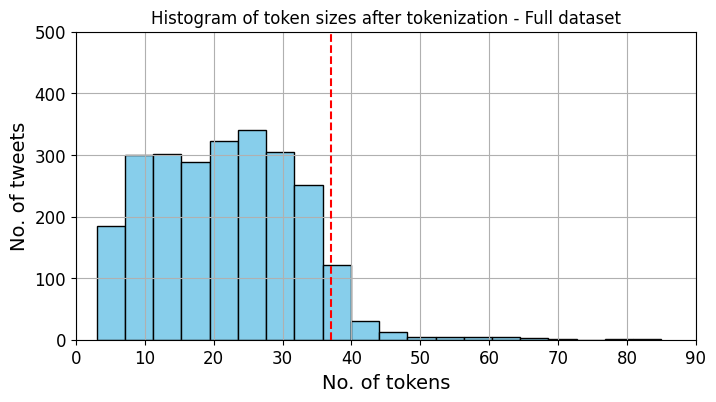

Maximum Tokens: 85
Minimum Tokens: 3
Average Tokens: 21.72
For: roberta-base
----------------------------------------------------------------------
PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

[0, 1694, 214, 59, 5, 129, 82, 11, 42, 28696, 12105, 15698, 8, 202, 64, 75, 120, 1268, 7, 244, 201, 479, 849, 31458, 268, 8649, 2463, 28696, 6423, 15698, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

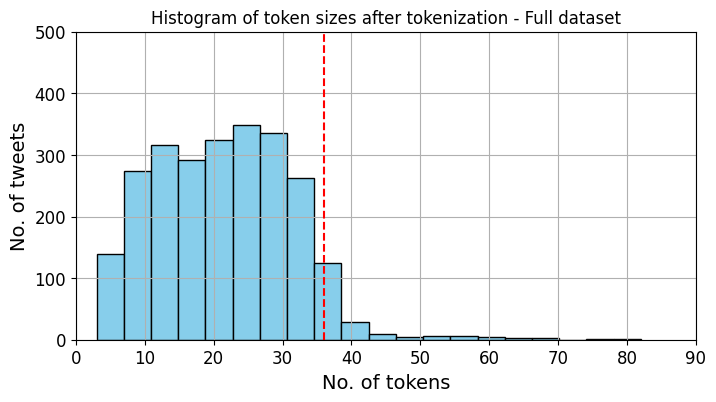

Maximum Tokens: 82
Minimum Tokens: 3
Average Tokens: 21.24
For: albert-base-v2
----------------------------------------------------------------------
PreTrainedTokenizerFast(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

[2, 95, 22, 99, 88, 14, 104, 148, 19, 48, 13, 1, 16704, 1, 17, 174, 92, 22, 38, 164, 1276, 20, 448, 182, 13, 9, 6926, 4636, 262, 1263, 11449, 13, 1, 911, 255, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

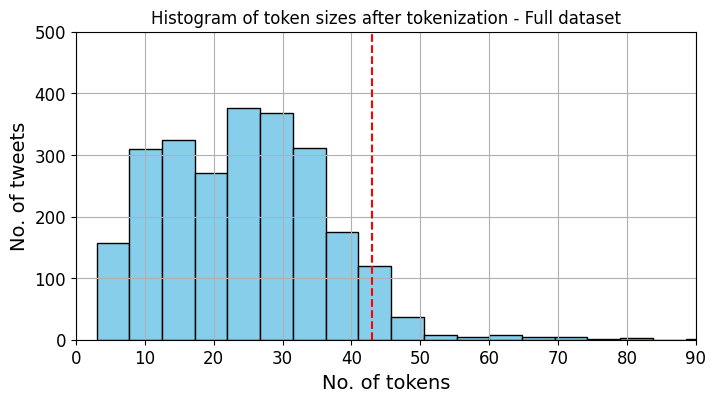

Maximum Tokens: 98
Minimum Tokens: 3
Average Tokens: 24.26
For: vinai/bertweet-base
----------------------------------------------------------------------


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


PreTrainedTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_len=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

[0, 4011, 81, 62, 6, 121, 83, 16, 33, 10584, 56843, 241, 13, 135, 129, 51, 400, 9, 272, 148, 4, 55329, 1027, 10584, 1556, 836, 241, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

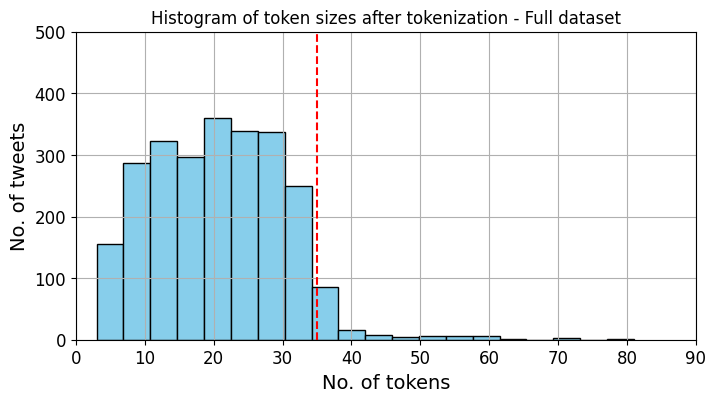

Maximum Tokens: 81
Minimum Tokens: 3
Average Tokens: 20.60
For: distilbert-base-uncased
----------------------------------------------------------------------
PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

[101, 2057, 1005, 2128, 2055, 1996, 2069, 2111, 1999, 2023, 1026, 5310, 1028, 1998, 2145, 2064, 1005, 1056, 2131, 3087, 2000, 2393, 2149, 1012, 1001, 6304, 2121, 7903, 2063, 1026, 24471, 2140, 1028, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

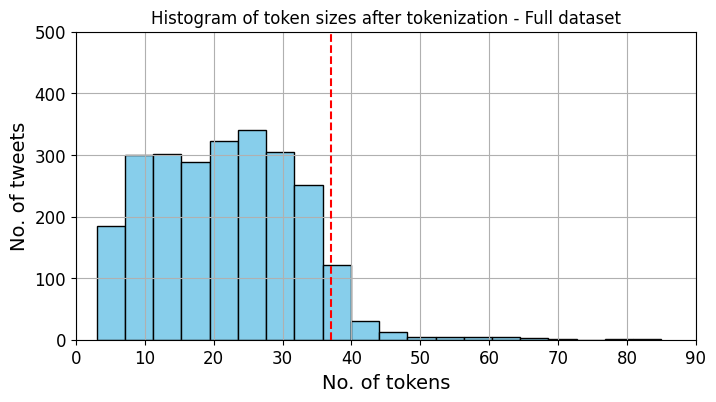

Maximum Tokens: 85
Minimum Tokens: 3
Average Tokens: 21.72
For: google/mobilebert-uncased
----------------------------------------------------------------------


PreTrainedTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

[101, 2057, 1005, 2128, 2055, 1996, 2069, 2111, 1999, 2023, 1026, 5310, 1028, 1998, 2145, 2064, 1005, 1056, 2131, 3087, 2000, 2393, 2149, 1012, 1001, 6304, 2121, 7903, 2063, 1026, 24471, 2140, 1028, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

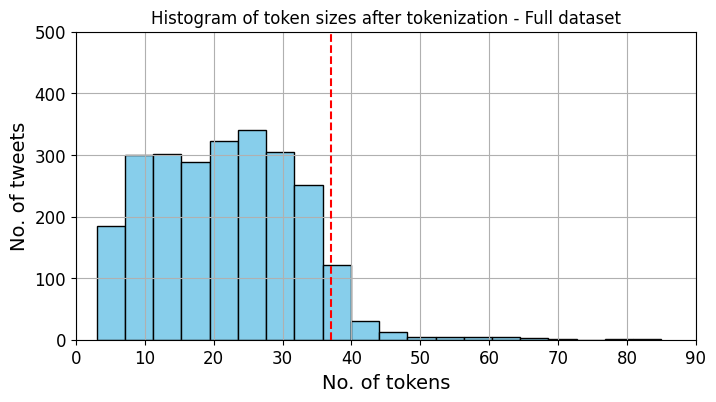

Maximum Tokens: 85
Minimum Tokens: 3
Average Tokens: 21.72
For: prajjwal1/bert-tiny
----------------------------------------------------------------------


PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

[101, 2057, 1005, 2128, 2055, 1996, 2069, 2111, 1999, 2023, 1026, 5310, 1028, 1998, 2145, 2064, 1005, 1056, 2131, 3087, 2000, 2393, 2149, 1012, 1001, 6304, 2121, 7903, 2063, 1026, 24471, 2140, 1028, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

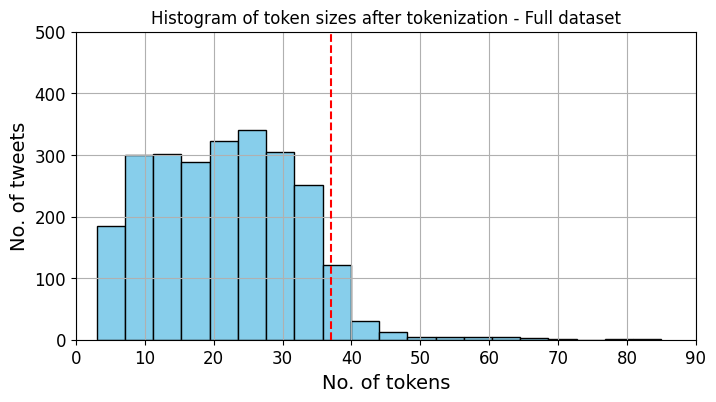

Maximum Tokens: 85
Minimum Tokens: 3
Average Tokens: 21.72


In [22]:
# "bert-base-uncased"
# "roberta-base"
# "albert-base-v2"
# "vinai/bertweet-base"
# "distilbert-base-uncased"
# "google/mobilebert-uncased"
# "prajjwal1/bert-tiny"

def generate_posttknz_hist(model_name):
    print("For:", model_name)
    print("-"*70)
    train_dataset, eval_dataset, test_dataset = tokenise_datasets(model_name, 
                                                                      twt_datasets)
    print(train_dataset[0].get("input_ids"))
    token_sizes = []
    sample_flag = 0
    for ds in train_dataset:
        inpt_ids = ds.get("input_ids")
        #if (sample_flag<11):
            #print("ENCODED:", inpt_ids)
            #print("DECODED:", tokenizer.decode(inpt_ids))
            #print("---")
            #sample_flag += 1
        if model_name in ["roberta-base", "vinai/bertweet-base"]:
            non_zero_count = sum(1 for num in inpt_ids if num != 1) # For BPE or Byte level BPE
        else:
            non_zero_count = sum(1 for num in inpt_ids if num != 0) # For Wordpiece, sentencepiece
        #print(non_zero_count)
        token_sizes.append(non_zero_count)

    token_sizes_pd = pd.DataFrame(token_sizes, columns=['sizes'])    
    create_histogram(token_sizes_pd['sizes'],
                     "token_pp_hist_" + model_name.replace("/", "-") + ".png",
                     'Histogram of token sizes after tokenization - Full dataset',
                     'No. of tokens',
                     'No. of tweets',
                     [0, 90],
                     [0, 500],
                     True)
    # Calculate statistics
    token_sizes_np = np.array(token_sizes)
    max_size = np.max(token_sizes_np)
    min_size = np.min(token_sizes_np)
    mean_size = np.mean(token_sizes_np)
    # Print statistics
    print(f"Maximum Tokens: {max_size}")
    print(f"Minimum Tokens: {min_size}")
    print(f"Average Tokens: {mean_size:.2f}")

MAX_LENGTH=512 # Run for max just to get stats, make sure the global variable is set back to the required value after.
generate_posttknz_hist("bert-base-uncased")
generate_posttknz_hist("roberta-base")
generate_posttknz_hist("albert-base-v2")
generate_posttknz_hist("vinai/bertweet-base")
generate_posttknz_hist("distilbert-base-uncased")
generate_posttknz_hist("google/mobilebert-uncased")
generate_posttknz_hist("prajjwal1/bert-tiny")
MAX_LENGTH=50


## Run for requirements file only

In [4]:
pip install pipreqs

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=1575e2075d850df1a8d68c38e206e0d3d75dbd3fc1d942ebc98e24ae02b959f1
  Stored in directory: /root/.cache/pip/wheels/4e/29/5e/e5f6f558e24e0d70f6808e3e8fdaf2c04ff597233098afc550
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.


In [7]:
!pipreqs

INFO: Successfully saved requirements file in /notebooks/requirements.txt


In [3]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [9]:
from torchsummary import summary

model_tst = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
print(summary(model_tst))


model_tst = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)
print(summary(model_tst))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               23,440,896
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            1,538
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               23,440,896
|    |    └─Embedding: 3-2     